<a href="https://colab.research.google.com/github/lupis30puc/yelp_bert_random_forest/blob/lupis30puc-update-1/Yelp_polarity_trainning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yelp Polarity on kaggle](https://www.kaggle.com/irustandi/yelp-review-polarity)

1,569 samples from the Yelp Dataset Challenge 2015. This subset has 280,000 training samples and 19,000 test samples in each polarity.

I follow this tutorial: 
[BERT Fine-Tunning](http://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification)
[Colab: BERT for sequential classification](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=DEfSbAA4QHas)


In [1]:
!pip install transformers

     |████████████████████████████████| 1.5MB 7.2MB/s 
     |████████████████████████████████| 2.9MB 29.6MB/s 
     |████████████████████████████████| 890kB 52.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=057b6f5e8550a0a6dbcad958a353d21e96fa8846507ec479dff53366d5d5b475
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Set up

## GPU

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## Loading the pre-processed dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import re

In [ ]:
#cols = ['label', 'text']
#df_2 = pd.read_csv('/content/drive/MyDrive/Yelp/test.csv', header=None, names=cols)
sample_df = pd.read_csv('/content/drive/MyDrive/Yelp/test_sample_10000.csv')


In [ ]:
sample_df.drop(labels=['Unnamed: 0', ])
sample_df.head()
# I COULD FIX THIS DF, SIMPLIFY IT

,Unnamed: 0,label,text,tokenized,len
0,25854,1,"Forget the rest, they're busy for a reason, I ...","[5293, 1996, 2717, 1010, 2027, 1005, 2128, 569...",38
1,4802,0,"So, I ordered delivery again. And, again, ever...","[2061, 1010, 1045, 3641, 6959, 2153, 1012, 199...",146
2,32973,0,"What can I say about the food...BBB. Blah, Bl...","[2054, 2064, 1045, 2360, 2055, 1996, 2833, 101...",626
3,8761,0,I was pressed for time and desperate for a fil...,"[1045, 2001, 4508, 2005, 2051, 1998, 7143, 200...",325
4,285,1,"Great service - very quick, definitely use the...","[2307, 2326, 1011, 2200, 4248, 1010, 5791, 222...",31


Extract the tokenized texts and labels

In [ ]:
# Get the lists of sentences and their labels.
reviews = sample_df.text.values
labels = sample_df.label.values

# BERT

## BERT Tokenizer

In [ ]:
# IS THIS NECESSARY?
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
%%time
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in reviews:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation = True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', reviews[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Forget the rest, they're busy for a reason, I just gotta learn to speak Spanish (they speak English, but it might seem more authentic if I can order in Spanish).
Token IDs: tensor([  101,  5293,  1996,  2717,  1010,  2027,  1005,  2128,  5697,  2005,
         1037,  3114,  1010,  1045,  2074, 10657,  4553,  2000,  3713,  3009,
         1006,  2027,  3713,  2394,  1010,  2021,  2009,  2453,  4025,  2062,
        14469,  2065,  1045,  2064,  2344,  1999,  3009,  1007,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
CPU times: user 31.2 s, sys: 24.3 ms, total: 31.2 s
Wall time: 31.3 s


Training splits

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,000 training samples
1,000 validation samples


In [ ]:
train_dataset[0]

(tensor([  101,  5404,   999,  2045,  2003,  2025,  2172,  2842,  2000,  2360,
           999,  1996,  5404,  4989,  2182,  2012, 24185,  2497,  2003, 12476,
          2007,  2058,  2753, 13618, 25316,  1998,  2184,  5404, 10424,  8004,
          2015,  2016, 25780,  5606,  1997, 11015,  2130,  2070,  2570, 18153,
         16310,   999, 24185,  2497,  2038,  4968,  2004,  2092,  2004,  4655,
          2035,  2058,  1996,  2088,  2007,  2035,  2367,  3976,  2685,  1998,
          4127,  1012,  2043,   102]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor(1))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
%%time
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CPU times: user 13.3 s, sys: 2.94 s, total: 16.2 s
Wall time: 24.4 s


optimizer

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

to save the model:
From: [Sentiment analysis with Yelp and Bert- From Gil Fernandez](https://github.com/onepointconsulting/yelp_bert/blob/master/bert_training.ipynb)

In [ ]:
path= '/content/drive/MyDrive/Yelp/'
import os
import shutil
import pickle

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

def save_model(model, tokenizer, output_dir = '/content/drive/MyDrive/Yelp/model_save'):

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    print(f"Saving model to {output_dir}")

    tokenizer.save_pretrained(output_dir)
    torch.save(model, output_dir/'model-28-DIC')


training

In [ ]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


# Trying out the version from Gil

In [ ]:
from tqdm.auto import tqdm

In [ ]:
def grab_batch_data(batch):
    input_ids = batch[0].to(device)
    input_mask = batch[1].to(device)
    labels = batch[2].to(device)
    return input_ids, input_mask, labels

def eval_fn():
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            loss_logits = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask,
                                   labels=labels)
            loss = loss_logits[0]
            logits = loss_logits[1]
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    return {
        'Accuracy': avg_val_accuracy,
        'Validation Loss': avg_val_loss
    }

In [ ]:
training_stats = []
best_accuracy = 0
total_train_loss = 0
model.train()
for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids, input_mask, labels = grab_batch_data(batch)
    model.zero_grad()  
    loss_logits = model(input_ids, 
                          token_type_ids=None, 
                          attention_mask=input_mask, 
                          labels=labels)
    loss = loss_logits[0]
    logits = loss_logits[1]
    total_train_loss += loss.item()
    if step % 2000 == 0:
        print(f'{step}: Loss: {total_train_loss / (step + 1)}\r')
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

avg_train_loss = total_train_loss / len(train_dataloader)
print("")
print(f"  Average training loss: {avg_train_loss}")
stats_info = eval_fn()
stats_info['epoch'], stats_info['Average training loss'] = 1, avg_train_loss
training_stats.append(stats_info)


0: Loss: 0.31237703561782837


  Average training loss: 0.2518943356389695



  Accuracy: 0.87
  Validation Loss: 0.28


In [ ]:
    tokenizer.save_pretrained('/content/drive/MyDrive/Yelp/output_dir_1')
    torch.save(model, '/content/drive/MyDrive/Yelp/output_dir_1/model')

In [ ]:
#save_model(model, tokenizer, output_dir='/content/drive/MyDrive/Yelp/output_dir_1')
save_model(model, tokenizer)
if stats_info['Accuracy'] > best_accuracy:
    save_model(model, tokenizer, output_dir='/content/drive/MyDrive/Yelp/output_dir_best')
    best_accuracy = stats_info['Accuracy']

Saving model to /content/drive/MyDrive/Yelp/model_save


TypeError: ignored

# EL otro

---



In [ ]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss_logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = loss_logits[0]
        logits = loss_logits[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss_logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = loss_logits[0]
            logits = loss_logits[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:29.
  Batch    80  of    282.    Elapsed: 0:00:58.
  Batch   120  of    282.    Elapsed: 0:01:26.
  Batch   160  of    282.    Elapsed: 0:01:55.
  Batch   200  of    282.    Elapsed: 0:02:24.
  Batch   240  of    282.    Elapsed: 0:02:52.
  Batch   280  of    282.    Elapsed: 0:03:21.

  Average training loss: 0.20
  Training epcoh took: 0:03:22

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.25
  Validation took: 0:00:07

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:29.
  Batch    80  of    282.    Elapsed: 0:00:57.
  Batch   120  of    282.    Elapsed: 0:01:26.
  Batch   160  of    282.    Elapsed: 0:01:55.
  Batch   200  of    282.    Elapsed: 0:02:23.
  Batch   240  of    282.    Elapsed: 0:02:52.
  Batch   280  of    282.    Elapsed: 0:03:21.

  Average training loss: 0.11
  Training epcoh took: 0:03:22

Running Validation...
  Accuracy: 0.90
 

SAVING MODEL

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/Yelp/output_dir_2')
torch.save(model, '/content/drive/MyDrive/Yelp/output_dir_2/model-28-DEC')

# Summary of training process

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.20,0.25,0.90,0:03:22,0:00:07
2,0.11,0.28,0.90,0:03:22,0:00:07
3,0.06,0.39,0.90,0:03:22,0:00:07
4,0.03,0.42,0.91,0:03:21,0:00:07
5,0.02,0.42,0.91,0:03:21,0:00:07


INSERT EXPLANATION HERE

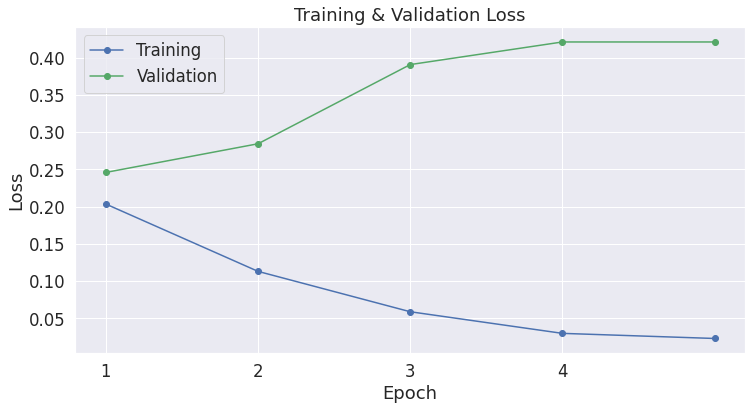

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()